In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import numpy as np

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import os
import sys
from pathlib import Path
import IPython.display as ipd
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Plot.BodeDiagram import bode_diagram_gain

import schemdraw
import schemdraw.elements as elm
from schemdraw import logic

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

import json
from IPython.display import display, HTML
from IPython.display import Javascript

display(HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/Chart.js/3.5.0/chart.min.js" integrity="sha512-asxKqQghC1oBShyhiBwA+YgotaSYKxGP1rcSYTDrB0U6DxwlJjU59B67U8+5/++uFjcuVM8Hh5cokLjZlhm3Vg==" crossorigin="anonymous" referrerpolicy="no-referrer"></script>
'''))

The CD4069UB device consist of six CMOS inverter circuits. These devices are intended for all generalpurpose inverter applications where the mediumpower TTL-drive and logic-level-conversion. This device is not ideal for linear amplification, but can be used as such and will add a lot of soft-clipping. Soft-clipping is expected from a valve. This makes this device special for musical usage and can be found in guitar distortion pedals [[2](http://www.runoffgroove.com/ubescreamer.html)] or the wasp filter [[3](https://www.schmitzbits.de/wasp.html)]. 

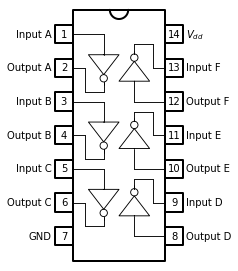

In [2]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=0.9)
d += (Q := elm.IcDIP(pins=14, lw=2)
             .label('Input A', loc='p1', fontsize=10)
             .label('Output A', loc='p2', fontsize=10)
             .label('Input B', loc='p3', fontsize=10)
             .label('Output B', loc='p4', fontsize=10)
             .label('Input C', loc='p5', fontsize=10)
             .label('Output C', loc='p6', fontsize=10)
             .label('GND', loc='p7', fontsize=10)

             .label('Output D', loc='p8', fontsize=10)
             .label('Input D', loc='p9', fontsize=10)
             .label('Output E', loc='p10', fontsize=10)
             .label('Input E', loc='p11', fontsize=10)
             .label('Output F', loc='p12', fontsize=10)
             .label('Input F', loc='p13', fontsize=10)
             .label('$V_{dd}$', loc='p14', fontsize=10))

d += elm.Line().at(Q.p1_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p2_in)
d += elm.Line("left").tox(Q.p2_in)

d += elm.Line("right").at(Q.p3_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p4_in)
d += elm.Line("left").tox(Q.p4_in)

d += elm.Line("right").at(Q.p5_in).length(d.unit/2.5)
d += (op := logic.Not("down").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("left").length(d.unit/4)
d += elm.Line("up").toy(Q.p6_in)
d += elm.Line("left").tox(Q.p6_in)

d += elm.Line("left").at(Q.p8_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p9_in)
d += elm.Line("right").tox(Q.p9_in)

d += elm.Line("left").at(Q.p10_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p11_in)
d += elm.Line("right").tox(Q.p11_in)

d += elm.Line("left").at(Q.p12_in).length(d.unit/2.5)
d += (op := logic.Not("up").anchor('start').scale(1).length(d.unit*0.75))
d += elm.Line("right").length(d.unit/4)
d += elm.Line("down").toy(Q.p13_in)
d += elm.Line("right").tox(Q.p13_in)

d.draw()

the chip should be powered by +5V/GND. With higher voltage the heat dissipation will be to big and the chip will be damaged. the chip is powered on pin 7 and 14 with +5V and Ground. the other pins can be used as amplifier. 

# voltage follower

the simplest circuit to begin with is a voltage follower or buffer. the buffer confifuration looks similar to the opamp buffer. but there are some differences. the first important difference is that the feedback will also do the biasing of the input signal. when an ac signal is applied to the buffer the output will be a dc signal, as long as the chip is able to provide the needed biasing feedback. the gain can be calculated similar to the opamp configuration. but there will be less gain as we would excpect from the calculation. 

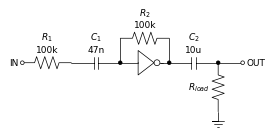

In [3]:
d = schemdraw.Drawing(unit=2, inches_per_unit=0.4, lw=0.7, fontsize=9)

d.add(elm.Dot('left', lftlabel='IN', open=True))
R = d.add(elm.Resistor(label='$R_1$\n100k'))
d.add(elm.Capacitor(label='$C_1$\n47n'))
N = d.add(logic.Not)
C = d.add(elm.Capacitor(label='$C_2$\n10u'))
d.add(elm.Resistor("down",label='$R_{load}$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_2$\n100k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot('right', rgtlabel='OUT', open=True))

d.draw()

This is the first setup with the 4069 as voltage follower. C1 and C3 are the dc blocking capacitors. When we choose R1 and R2 as 100kOhm we would excpect a gain of one. 

In [4]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(2, 'gate_out', 'gate_in', 100@u_kΩ)
circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'IN', 100@u_kΩ)
circuit.C(2, 'gate_out', 'OUT', 1@u_uF)
R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

In [5]:
buffer_data = []

circuit.R2.resistance = 100000
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=10@u_us, start_time=1@u_ms, end_time=2@u_ms)

for r in range(100000,500000, 10000):
    circuit.R2.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis_step  = simulator.transient(step_time=10@u_us, start_time=1@u_ms, end_time=2@u_ms)
    buffer_data.append(analysis_step['OUT'].tolist())

In [6]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="myChart" class="400px"></canvas>
<input type="range" class="slider-width" id="buffer_resistance" name="Resistance" min="0" max="39" value="0" step="1"></input>
<p class="content">Figure 3: Linear Buffer Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var buffer_datas = %s;

const data = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: buffer_datas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var ctx = document.getElementById('myChart').getContext('2d');
var myChart = new Chart(ctx, {
    type: 'line',
    data: data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                }
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -3,
                max: 3,
                ticks: {
                    stepSize: 0.5
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

console.log("size: " + buffer_datas.length);
let resistance = document.getElementById('buffer_resistance');
resistance.addEventListener('input', function (e) {
    myChart.data.datasets[1].data = buffer_datas[resistance.value];
    myChart.update();

});

''' % (json.dumps(buffer_data), analysis['OUT'].abscissa.tolist(), analysis['IN'].tolist() ) ))

<IPython.core.display.Javascript object>

The blue line is the input signal (5V p2p) and the red the output signal with 100kOhm resistors. The output is a little less then excpected. For the other signals the resistor R2 is replaced with 125kΩ, 150kΩ, 175kΩ and 200kΩ. With 150kΩ the gain is roughly one. We also see that the ouput is not symetrical. The clipping occures earlier for the negative part of the signal. With higher gain the signal is soft clipped. 

# summer/mixer

The cmos inverter can also be used as summing amplifier. In this example two sinudiol signals are added. The setup is the same as an Opamp summing amplifiert. The gain can be adjusted with the feeback resistor. 


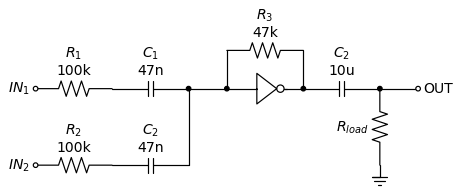

In [7]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.2)
d.add(elm.Dot('left', lftlabel='$IN_1$', open=True))
d.add(elm.Resistor(label='$R_1$\n100k'))
C1 = d.add(elm.Capacitor(label='$C_1$\n47n'))
d.add(logic.Dot())
d.add(elm.Line("down"))
d.add(elm.Capacitor("left", label='$C_2$\n47n'))
d.add(elm.Resistor(label='$R_2$\n100k'))
d.add(elm.Dot('left', lftlabel='$IN_2$', open=True))

d.add(elm.Line('right', xy=C1.end, l=d.unit/2))
N = d.add(logic.Not)


C = d.add(elm.Capacitor(label='$C_2$\n10u'))
d.add(elm.Resistor("down",label='$R_{load}$'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N.start))
d.add(elm.Line('up', l=d.unit/2))
d.add(elm.Resistor('right', label='$R_3$\n47k'))
d.add(elm.Line('down', l=d.unit/2))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot('right', rgtlabel='OUT', open=True))

d.draw()

In [8]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'INa', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')
circuit.V('3', 'INb', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 500)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(3, 'gate_out', 'gate_in', 47@u_kΩ)

circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'INa', 100@u_kΩ)

circuit.C(2, 'gate_in', 'R2out', 47@u_nF)
circuit.R(2, 'R2out', 'INb', 100@u_kΩ)

circuit.C(3, 'gate_out', 'OUT', 1@u_uF)

R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=4@u_ms)
buffer_data.append(np.array(analysis['OUT']))

f1 = 1
f2 = 0.5

N = 4008
# sample spacing
T = 0.001
x = np.linspace(0.0, N*T, N, endpoint=False)

y1 = np.sin(2 * f1 * np.pi * x)
y2 = np.sin(2 * f2 * np.pi * x)

In [9]:
circuit = Circuit('cmos buffer')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'INa', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 1k)')
circuit.V('3', 'INb', circuit.gnd, 'DC 5 AC 2.5V SIN(0 2.5V 500 0 0 180)')

circuit.X('1', '4069UB', 'gate_in', 'gate_out', '+5V', circuit.gnd)
circuit.R(3, 'gate_out', 'gate_in', 47@u_kΩ)

circuit.C(1, 'gate_in', 'R1out', 47@u_nF)
circuit.R(1, 'R1out', 'INa', 100@u_kΩ)

circuit.C(2, 'gate_in', 'R2out', 47@u_nF)
circuit.R(2, 'R2out', 'INb', 100@u_kΩ)

circuit.C(3, 'gate_out', 'OUT', 1@u_uF)

R = circuit.R('load', 'OUT', circuit.gnd, 100@u_kΩ)


simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis_diff  = simulator.transient(step_time=1@u_us, start_time=0@u_ms, end_time=4@u_ms)



In [10]:
f1 = 1
f2 = 0.5

N = 4008
# sample spacing
T = 0.001
x_diff = np.linspace(0.0, N*T, N, endpoint=False)

y_diff1 = np.sin(2 * f1 * np.pi * x_diff)
y_diff2 = np.sin(2 * f2 * np.pi * x_diff)

sum_values = []
diff_values = []

for step in np.arange(0, analysis['OUT'].size) :
    sum_values.append( -1*(y1[step]+y2[step]) )
    diff_values.append( -1*(y_diff1[step]-y_diff2[step]) )
              

A differential amplifier can not be configured like an Opamp amplifier. But when the inverse is added the result is a substraction of the two signals. This is the same simulation but the second signal has a phase shift of 180°.

In [11]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="diff_chart" class="400px"></canvas>
<p class="content">Figure 5: Summing Amplifier Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
const sum_data = {
  labels: %s,
    datasets: [
    {
      label: 'Dataset 1',
      legend: false,
      data: %s,
      fill: false,
      borderColor: 'rgb(224, 224, 224)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 5
    },
    {
      label: 'Dataset 1',
      data: %s,
      fill: false,
      borderColor: 'rgb(224, 224, 224)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 5
    },
    {
      label: 'sum',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'diff',
      data: %s,
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var ctx = document.getElementById('diff_chart').getContext('2d');
var diff_chart = new Chart(ctx, {
    type: 'line',
    data: sum_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                   filter: function(legendItem, chartData) {
                    if (legendItem.datasetIndex === 0 || legendItem.datasetIndex === 1) {
                      return false;
                    }
                   return true;
                   }
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } 
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -2,
                max: 2,
                ticks: {
                    stepSize: 0.5
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});
''' % (json.dumps(analysis['OUT'].abscissa.tolist()), json.dumps(sum_values), json.dumps(diff_values), json.dumps(analysis['OUT'].tolist()), json.dumps(analysis_diff['OUT'].tolist()) ) ))

<IPython.core.display.Javascript object>

The grey line is the calculated result and the blue line the simulated result. The actual result is close to the calculated one. here the feedback resistor has about half of the input resistors.

# distortion

# Way Huge Red LLama

In [12]:
from IPython.core.display import display, HTML
display(HTML('''
<div class="hero is-medium" style="background: url('{{ '/assets/electronics_projects.jpg' | relative_url }}') no-repeat center center; background-size: cover; background-attachment: fixed;">
   <div class="hero-body">
        <div class="content has-text-centered">
        </div>
    </div>
</div>
'''))

The Red Llama is actually a clone itself with some component changes. The original designer of the circuit is Craig Anderson. In an interview with Jeorge Tripps, creator of the way huge line, he said that he had bought this book called "Electronic Projects for Musicians" written by Craig Anderson. He also said that the first pedal he built was the Tube Sound Fuzz that was that book. Once I heard that this book existed, I quickly got it. In this book, Craig Anderson talks about the circuit. He explains how it works, why it works, and the reason it sounds so good.


The soft clipping, which is the special characteristic of valves, adds harmonics to the signal. Here we want to analyse what harmonics are added. therefore we add a second stage to out circuit. the first stage is a voltage follower with the gain of one (or less as saw). the second stage is a high gain stage. the simulation is done with different values for R4.

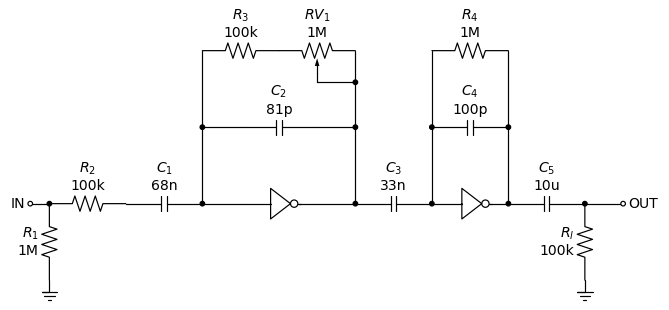

In [13]:
d = schemdraw.Drawing(unit=2.5, inches_per_unit=0.5, lw=1.2)
d.add(elm.Dot('left', lftlabel='IN', open=True))
Lin = d.add(elm.Line(l=d.unit/4))
d.add(elm.Dot())
d.add(elm.Resistor("down", label='$R_1$\n1M'))
d.add(elm.Ground())
R1 = d.add(elm.Resistor("right", label='$R_2$\n100k', at=Lin.end))
d.add(elm.Capacitor(label='$C_1$\n68n'))
N1 = d.add(elm.Line(l=d.unit/2))
d.add(logic.Not)
d.add(elm.Line(l=d.unit/2))

C3 = d.add(elm.Capacitor(label='$C_3$\n33n'))
N2 = d.add(logic.Not)

C = d.add(elm.Capacitor(label='$C_5$\n10u'))
d.add(elm.Resistor("down",label='$R_l$\n100k'))
d.add(elm.Ground)

d.add(logic.Dot(xy=N1.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Dot())
C2 = d.add(elm.Line("right", l=d.unit/2))
d.add(elm.Capacitor(label="$C_2$\n81p"))
LC2 = d.add(elm.Line(l=d.unit/2))

d.add(elm.Line("up", l=d.unit, at=C2.start))
d.add(elm.Resistor('right', label='$R_3$\n100k'))
RV1 = d.add(elm.Potentiometer(flip=True, toplabel="$RV_1$\n1M"))
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(elm.Line("down", l=d.unit/8, at=RV1.tap))
d.add(elm.Line("right", tox=LC2.end))
d.add(elm.Dot)

d.add(logic.Dot(xy=N2.start))
d.add(elm.Line('up', l=d.unit))
d.add(elm.Dot())
C4 = d.add(elm.Capacitor("right", label="$C_4$\n100p"))

d.add(elm.Line("up", l=d.unit, at=C4.start))
d.add(elm.Resistor('right', label='$R_4$\n1M'))
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())
d.add(elm.Line('down', l=d.unit))
d.add(logic.Dot())

d.add(logic.Dot(xy=C.end))
d.add(elm.Line('right', l=d.unit/2))
d.add(elm.Dot('right', rgtlabel='OUT', open=True))

d.draw()

in the simulation R2 is unchanched. For R4 the simulation is done with 100kΩ, 500kΩ, 1MΩ and 10MΩ.

In [14]:
circuit = Circuit('cmos buffer with distortion')
circuit.include(spice_library['4069UB'])

circuit.V('1', '+5V', circuit.gnd, 'DC 5')
circuit.V('2', 'IN', circuit.gnd, 'DC 5 AC 2.5V SIN(0 1V 1k)')

circuit.X('1', '4069UB', 'gate_in_1', 'gate_out_1', '+5V', circuit.gnd)
circuit.X('2', '4069UB', 'gate_in_2', 'gate_out_2', '+5V', circuit.gnd)

circuit.R(1, 'IN', circuit.gnd, 1@u_MΩ)
circuit.R(2, 'IN', "R2out", 100@u_kΩ)
circuit.C(1, 'R2out', 'gate_in_1', 68@u_nF)
circuit.C(2, 'gate_in_1', 'gate_out_1', 81@u_pF)
circuit.R(3, 'gate_in_1', 'R3out', 100@u_kΩ)
circuit.R(6, 'R3out', 'gate_out_1', 1@u_MΩ)

circuit.C(3, 'gate_out_1', 'gate_in_2', 33@u_nF)

circuit.C(4, 'gate_in_2', 'gate_out_2', 100@u_pF)
circuit.R(4, 'gate_in_2', 'gate_out_2', 1@u_MΩ)

circuit.C(5, 'gate_out_2', 'C5out', 1@u_uF)
circuit.R(5, 'C5out', 'OUT', 100@u_kΩ)
R = circuit.R('load', 'OUT', circuit.gnd, 50@u_kΩ)

In [15]:
buffer_data = []

circuit.R6.resistance = 100000
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.options('INTERP')
analysis  = simulator.transient(step_time=10@u_us, start_time=1@u_ms, end_time=2@u_ms)

for r in range(1000,1000000, 10000):
    circuit.R6.resistance = r

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    simulator.options('INTERP')
    analysis_step  = simulator.transient(step_time=10@u_us, start_time=1@u_ms, end_time=2@u_ms)
    buffer_data.append(analysis_step['OUT'].tolist())    

In [16]:
display(HTML('''
<div class="columns is-centered">
<div class="column is-half">
<div class="content has-text-centered">
<canvas id="dist_Chart" class="400px"></canvas>
<input type="range" class="slider-width" id="dist_resistance" name="Resistance" min="0" max="98" value="0" step="1"></input>
<p class="content">Figure 7: Way Huge Red LLama Analysis.</p>
</div>
</div>
</div>
'''))

display(Javascript('''
var dist_datas = %s;

const dist_data = {
  labels: %s,
    datasets: [
    {
      label: 'Input',
      data: %s,
      fill: false,
      borderColor: 'rgb(0, 0, 204)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    },
    {
      label: 'Output',
      data: dist_datas[0],
      fill: false,
      borderColor: 'rgb(255, 99, 132)',
      pointRadius: 0,
      tension: 0.1,
      borderWidth: 2
    }]
};
var ctx = document.getElementById('dist_Chart').getContext('2d');
var dist_Chart = new Chart(ctx, {
    type: 'line',
    data: dist_data,
    options: {
        plugins: {
            legend: {
               labels: {
                   boxHeight: 1,
                }
            }
        },
        scales: {
            x: {
                title: {
                    display: true,
                    text: '[ms]'
                },
                ticks: {
                    maxTicksLimit: 9,
                    callback: function(value, index) {
                        return (this.getLabelForValue(value) * 1000).toFixed(1);
                    }                
                } 
            },
            y: {
                title: {
                    display: true,
                    text: '[V]'
                },
                min: -1.1,
                max: 1.1,
                ticks: {
                    stepSize: 0.5
                }
            }
        },
        responsive: true,
        maintainAspectRatio: true,
        animation: {
            duration: 0
        }
    }
});

console.log("size: " + dist_datas.length);
let dist_resistance = document.getElementById('dist_resistance');
dist_resistance.addEventListener('input', function (e) {
    dist_Chart.data.datasets[1].data = dist_datas[dist_resistance.value];
    dist_Chart.update();

});

''' % (json.dumps(buffer_data), analysis['IN'].abscissa.tolist(), analysis['IN'].tolist() ) ))

<IPython.core.display.Javascript object>

the simulation looks similar to the first one. we can see that the signal is transforming into a square wave, but always with the soft clipping. next we want to analyse the harmonics that are added to the signal.

# references

1. [CD4069](https://www.ti.com/lit/ds/schs054e/schs054e.pdf) Datasheet
2. [UBE Screamer](http://www.runoffgroove.com/ubescreamer.html) TS-808 workalike built around the CD4049UBE logic IC
3. [WASP Filter](https://www.schmitzbits.de/wasp.html) Jürgen Haibles clone of the EDP Wasp VCF from René Schmitz.